<a href="https://colab.research.google.com/github/GashonHussein/CNN-PneumoniaClassification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests, zipfile, io
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from io import BytesIO
import random
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import tensorflow as tf
import requests

# Seed value for weight initialization
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload() #Upload kaggle.json file

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia #Use API token to download dataset
! unzip chest-xray-pneumonia.zip
base_path = 'chest_xray'
train_path = base_path + 'train'
val_path = base_path + 'val'
test_path = base_path + 'test'

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
def visualize_images(set_name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)

    pneumonia_images = os.path.join('chest_xray', set_name, 'PNEUMONIA')
    pneumonia_path = os.path.join(pneumonia_images, os.listdir(pneumonia_images)[0])
      
    im = Image.open(pneumonia_path)
    ax1.imshow(im)

    normal_images = os.path.join('chest_xray', set_name, 'NORMAL')
    normal_path = os.path.join(normal_images, os.listdir(normal_images)[0])
      
    im = Image.open(normal_path)
    ax2.imshow(im)

    plt.show()

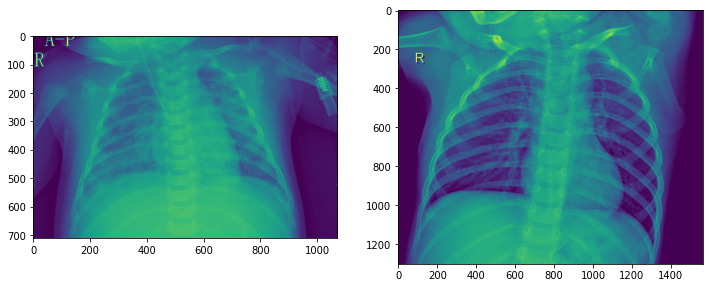

In [ ]:
visualize_images("val")

In [ ]:
batch_size = 32 

def get_data_generator(set_name, batch_size):
    datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = set_name == 'train')
    generator = datagen.flow_from_directory('./chest_xray/' + set_name,
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')
    return generator
    
train_generator = get_data_generator('train', batch_size)
val_generator = get_data_generator('val', batch_size)
test_generator = get_data_generator('test', batch_size)

num_classes = 2

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
lr = 1e-3

def get_base_resnet_model(lr):
    model = tensorflow.keras.applications.ResNet50(include_top = True, weights = None, 
                                        classes = num_classes, input_shape=(224, 224, 3), 
                                        input_tensor = None)

    optim = optimizers.Adam(lr = lr)
    model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics=['accuracy'])

    return model
    
base_resnet_model = get_base_resnet_model(lr)
base_resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

In [ ]:
base_resnet_model.fit(train_generator, epochs=5)
base_resnet_model.evaluate_generator(val_generator, len(val_generator))

Epoch 1/5
163/163 [==============================] - 89s 433ms/step - loss: 0.3461 - accuracy: 0.8949
Epoch 2/5
163/163 [==============================] - 70s 430ms/step - loss: 0.1386 - accuracy: 0.9482
Epoch 3/5
163/163 [==============================] - 75s 457ms/step - loss: 0.1009 - accuracy: 0.9613
Epoch 4/5
163/163 [==============================] - 73s 445ms/step - loss: 0.0963 - accuracy: 0.9670
Epoch 5/5
163/163 [==============================] - 73s 446ms/step - loss: 0.0836 - accuracy: 0.9682


In [ ]:
lr = 1e-3

def get_pretrained_resnet_model(lr):
    # here, we pass in weights = 'imagenet' instead of weights = None
    pretrained_resnet = tensorflow.keras.applications.ResNet50(include_top = False, weights = 'imagenet', 
                                                    classes = num_classes, input_shape = (224, 224, 3), 
                                                    input_tensor = None)
    # replace last layer (including the pooling)
    h = GlobalAveragePooling2D()(pretrained_resnet.output)
    y_hat = Dense(num_classes, activation = 'softmax', name = 'fc1000')(h)
    
    model = Model(inputs = pretrained_resnet.input, outputs = y_hat)

    optim = optimizers.Adam(lr = lr)
    model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics=['accuracy'])

    return model
    
pretrained_resnet_model = get_pretrained_resnet_model(lr)
pretrained_resnet_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)       

In [ ]:
pretrained_resnet_model.fit(train_generator, epochs=1)
pretrained_resnet_model.evaluate_generator(val_generator, len(val_generator))

In [ ]:
lr = 1e-3
num_freeze_layers = 30

def get_pretrained_frozen_resnet_model(lr, num_freeze_layers):
    pretrained_resnet = tensorflow.keras.applications.ResNet50(include_top = False, weights = 'imagenet', 
                                                    classes = 31, input_shape = (224, 224, 3), 
                                                    input_tensor = None)
    # replace last layer (including the pooling)
    h = GlobalAveragePooling2D()(pretrained_resnet.output)
    y_hat = Dense(num_classes, activation = 'softmax', name = 'fc1000')(h)
    
    model = Model(inputs = pretrained_resnet.input, outputs = y_hat)

    optim = optimizers.Adam(lr = lr)
    model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    print('Freezing %d of %d model layers...' % (num_freeze_layers, len(model.layers)))
    
    if not num_freeze_layers:
        for layer in model.layers[:num_freeze_layers]:
            layer.trainable = False
        for layer in model.layers[num_freeze_layers:]:
            layer.trainable = True

    return model
    
pretrained_frozen_resnet_model = get_pretrained_frozen_resnet_model(lr, num_freeze_layers)
pretrained_frozen_resnet_model.summary()

Freezing 30 of 177 model layers...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
          

In [ ]:
pretrained_frozen_resnet_model.fit(train_generator, epochs=5)
pretrained_frozen_resnet_model.evaluate_generator(val_generator, len(val_generator))

Epoch 1/5
163/163 [==============================] - 77s 437ms/step - loss: 0.1455 - accuracy: 0.9549
Epoch 2/5
 17/163 [==>...........................] - ETA: 1:02 - loss: 0.0766 - accuracy: 0.9779

In [ ]:
loss, acc = pretrained_frozen_resnet_model.evaluate_generator(test_generator, len(test_generator))

print('Your best test loss was', loss)
print('Your best test accuracy was', acc)